In [23]:
## Initialization and imports
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt
import seaborn as sns

## Changing directory to top folder (All programs run from top)
import os
os.chdir('/Users/nschumacher/docs/galvanize/smunch-user-food-analysis')

from eda.python_db import run_sql_query

%matplotlib inline  
%config InlineBackend.figure_format='retina'

## Set random seed
np.random.seed(seed=14)

df1 = run_sql_query("Select * from noah.meal_rating_ingredients")
df2 = run_sql_query("Select * from noah.ingredients")

In [24]:
meal_ratings = df1.copy()
ingrds = df2.copy()

In [25]:
meal_ratings.sample(2)

,meal_id,meal_name,category,avg_meal_rating,rating_count,ingredient_ids
102,a050N00000zZfzWQAS,Salad with Tandoori Chicken,freakyfit,3.433099,142,"[a060N00002XMfW7QAL, a060N00002XMfYnQAL, a060N..."
480,a050N000010XxrMQAS,Quinoa Salad with Roast Bacon,powerpick,3.233333,30,"[a060N00002aa0DvQAI, a060N00002XMfYEQA1, a060N..."


In [26]:
ingrds.sample(2)

,ingredient_id,name
693,a060N00002Z7frfQAB,herb creme
123,a060N00002XMfceQAD,Sweet Chili Sauce


Avg Meal Rating 3.7294749231358164


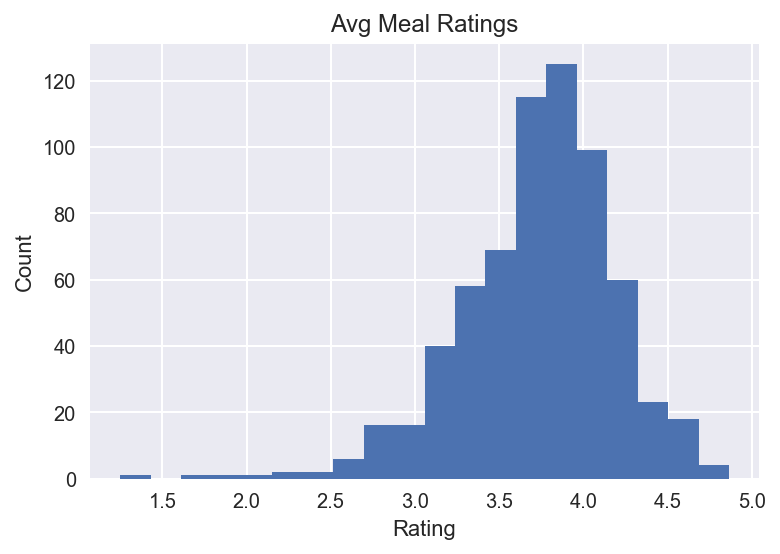

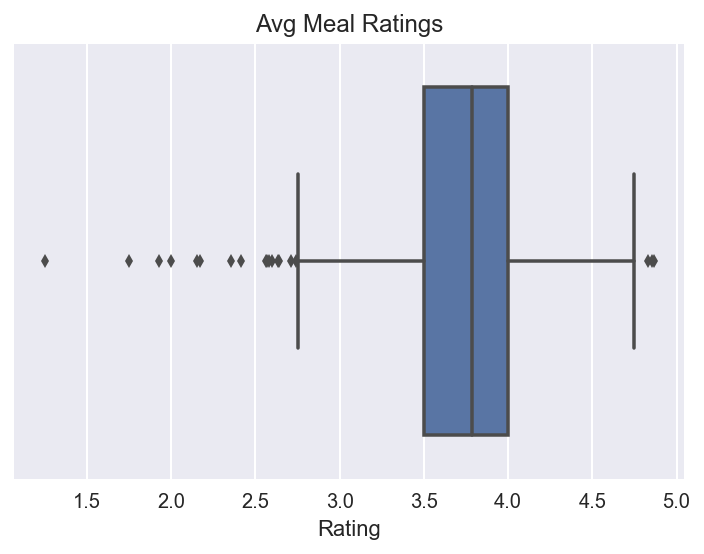

In [27]:
## Histogram of the avg meal ratings
print("Avg Meal Rating", meal_ratings.avg_meal_rating.mean())

meal_ratings.avg_meal_rating.hist(bins=20)
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Avg Meal Ratings")
plt.show()

## Box plot of same information
sns.boxplot(meal_ratings.avg_meal_rating)
plt.xlabel("Rating")
plt.title("Avg Meal Ratings")
plt.show()

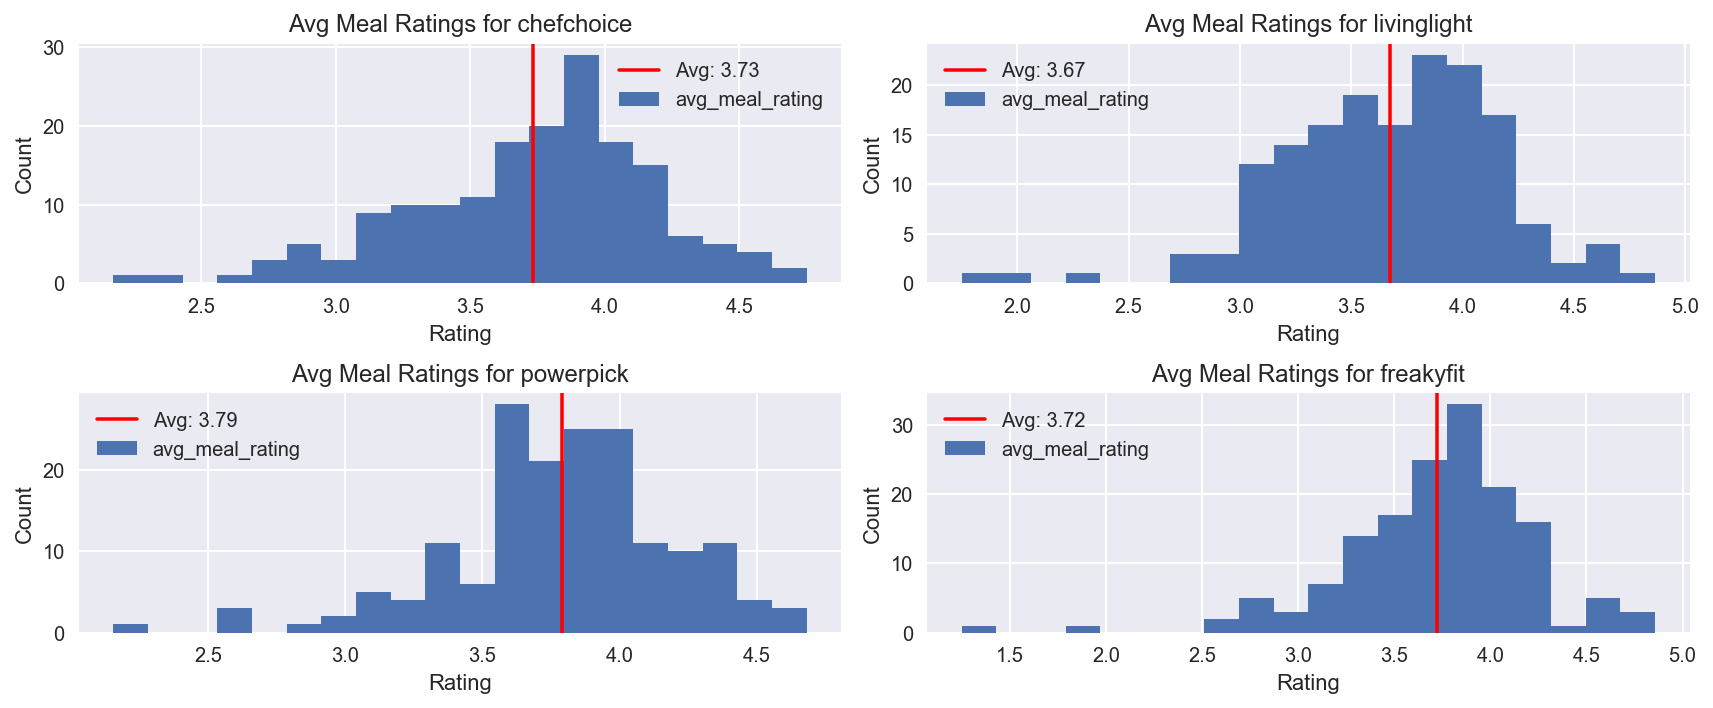

In [28]:
## Plotting rating for different categories  
cats = meal_ratings.category.unique()

fig, axs = plt.subplots(2, 2, figsize=(12,5))
axis = axs.flatten()

counter = 0
for cat in cats:
    df = meal_ratings.loc[meal_ratings.category == cat, :]
    avg = df.avg_meal_rating.mean()
    
    axis[counter].hist(df.avg_meal_rating, bins=20)
    axis[counter].axvline(avg, color='r', label="Avg: {0:3.2f}".format(avg))
    axis[counter].set_xlabel("Rating")
    axis[counter].set_ylabel("Count")
    axis[counter].legend()
    axis[counter].set_title("Avg Meal Ratings for {0}".format(cat))
    
    plt.tight_layout()
    counter += 1
    
plt.show()

* Above indicates that no strong difference in ratings of the different categories.

#### Expanding ingredients out into columns

In [29]:
meal_ratings.sample(3)

,meal_id,meal_name,category,avg_meal_rating,rating_count,ingredient_ids
455,a050N000010X9hmQAC,Fish Madras Curry,livinglight,3.750000,94,"[a060N00002XMfTXQA1, a060N00002Zo7Q5QAJ, a060N..."
377,a050N00000zZgG8QAK,Mixed Vietnamese style Salad with Salmon & Wakame,freakyfit,3.973333,150,"[a060N00002XMfXgQAL, a060N00002XMfVwQAL, a060N..."
498,a050N0000125SaJQAU,Sag Alu,chefchoice,4.583333,12,"[a060N00002bMwpzQAC, a060N00002XMfW9QAL, a060N..."


In [30]:
## Lemmatizing to merge similar ingredients
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer

wordnet = WordNetLemmatizer()
snowball = SnowballStemmer('english')

## Mapping ingredients to names:
def map_name(ll):
    l = [ingrds.loc[ingrds.ingredient_id == id].name for id in ll]
    l = [wordnet.lemmatize(val.values[0].lower()) for val in l if len(val) != 0]  ## few ids dont have names
    return set(l)

meal_ratings['ingredient_names'] = meal_ratings.ingredient_ids.apply(map_name)
meal_ratings.head(3)

,meal_id,meal_name,category,avg_meal_rating,rating_count,ingredient_ids,ingredient_names
0,a050N00000za4mZQAQ,Chicken Spanish Rice Burrito,chefchoice,4.111190,706,"[a060N00002XMfYqQAL, a060N00002XMfX1QAL, a060N...","{lemon juice, cumin, sour cream, garlic, tumer..."
1,a050N00000za4nlQAA,Rice & Tofu Teriyaki Curry,livinglight,3.940520,538,"[a060N00002XMfZxQAL, a060N00002XMfYIQA1, a060N...","{bell pepper, eggplant, rice, snap peas, coria..."
2,a050N00000za4nqQAA,Curried Salmon with Rice,powerpick,4.221017,1337,"[a060N00002XMfWcQAL, a060N00002XMfYIQA1, a060N...","{bell pepper, eggplant, rice, snap peas, coria..."


In [31]:
## Getting all the ingredients used in meals
ingredient_sets = meal_ratings.ingredient_names.tolist()

## Getting set of all the ingredients present in meal
ings = []
for s in ingredient_sets:
    for ing in s:
        ings.append(ing)
ings = list(set(ings))


## Creating the feature matrix and target
X = np.zeros((len(ingredient_sets), len(ings)))
y = np.array(meal_ratings.avg_meal_rating.tolist())

for i, ingredients in enumerate(meal_ratings.ingredient_names.tolist()):
    row = np.array([col in ingredients for col in ings]).astype(int)
    X[i] = row

Moving over to python file for model building...